# Numerical Analysis for Non-Linear Optimization | Module 2

## Introduction

Monte Carlo methods and **random number generation** serve as a cornerstone in **non-linear optimization** and **scientific computing**. They approximate solutions to deterministic problems via random sampling, and they also appear in **finance**, **risk analysis**, and **machine learning**. This module covers:

- **PRNGs vs. QRNs**, plus validation (Kolmogorov–Smirnov, histograms).  
- **Monte Carlo** fundamentals (estimating $\pi$, convergence).  
- **Brownian motion**: A key stochastic process for advanced models.  
- **Variance reduction** (antithetic variables, best samples).  
- **Moment control** to match specific mean/variance/skewness.  
- Applications to **financial modeling**: GBM, option pricing, VaR.

---

## Pseudo and Quasi-Random Number Generation

### Pseudo-Random Numbers (PRNs)

PRNs are deterministic but appear random:

- Typically **seed-based** (e.g., Mersenne Twister).  
- Standard for Monte Carlo simulations.

### Quasi-Random Numbers (QRNs)

Low-discrepancy sequences:

- **Sobol**, **Halton**, etc.  
- Provide **more uniform coverage**, often faster integration convergence.

### Comparison: PRNs vs. QRNs

| Feature       | PRNs (Pseudo-Random)          | QRNs (Quasi-Random)      |
|---------------|-------------------------------|--------------------------|
| Generation    | Seed-based algorithm          | Deterministic sequence   |
| Periodicity   | Yes (can be extremely long)   | None                     |
| Uniformity    | Moderate (by chance)          | High (low discrepancy)   |
| Integration   | $\sim 1/\sqrt{N}$             | Potentially faster       |
| Usage         | General Monte Carlo           | Integration, optimization|

### Implementation Examples

#### Using NumPy’s Modern PRNG API

In [30]:
import numpy as np

rng = np.random.default_rng(42)
random_nums = rng.random(10)
print(random_nums)

[0.77395605 0.43887844 0.85859792 0.69736803 0.09417735 0.97562235
 0.7611397  0.78606431 0.12811363 0.45038594]


#### Generating Secure Random Numbers

In [31]:
import secrets
import string

def generate_password(length=12):
    chars = string.ascii_letters + string.digits + string.punctuation
    return "".join(secrets.choice(chars) for _ in range(length))

print("Secure Password:", generate_password())

Secure Password: }Sm=-"n3}la@


#### Quasi-Random (Sobol)

In [32]:
from scipy.stats.qmc import Sobol

sobol = Sobol(d=2, scramble=False)
qrn_points = sobol.random(n=10)
print(qrn_points)

[[0.     0.    ]
 [0.5    0.5   ]
 [0.75   0.25  ]
 [0.25   0.75  ]
 [0.375  0.375 ]
 [0.875  0.875 ]
 [0.625  0.125 ]
 [0.125  0.625 ]
 [0.1875 0.3125]
 [0.6875 0.8125]]


/home/julihocc/ma2008b/notes.worktrees/FJ2025/.venv/lib/python3.12/site-packages/scipy/stats/_qmc.py:993: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  sample = self._random(n, workers=workers)


### Statistical Tests & Visualization

- **Kolmogorov–Smirnov** test to check uniformity.  
- **Histogram** + **KDE** for distribution checks.

---

## Monte Carlo Simulations: Fundamentals

### Estimating $\pi$ Using Monte Carlo

In [33]:
from numba import njit, prange
import numpy as np

@njit(parallel=True)
def monte_carlo_pi(n):
    count = 0
    for i in prange(n):
        x, y = np.random.random(), np.random.random()
        if x**2 + y**2 <= 1:
            count += 1
    return 4.0 * count / n

print("Monte Carlo Pi:", monte_carlo_pi(1000000))

Monte Carlo Pi: 3.142528


### Monte Carlo Convergence Analysis

In [34]:
import matplotlib.pyplot as plt

n_values = np.logspace(2, 6, num=20, dtype=int)
estimates = [monte_carlo_pi(n) for n in n_values]

plt.plot(n_values, estimates, marker='o', linestyle='--')
plt.xscale('log')
plt.axhline(y=$\pi$, color='red', linestyle='dashed', label="$\pi$")
plt.legend()
plt.show()

SyntaxError: invalid syntax (766589057.py, line 8)

---

## Brownian Motion

### Definition & Properties

A **standard Brownian motion** $W_t$:

1. $W_0=0$.  
2. Independent, stationary increments.  
3. $\mathbb{E}[W_t]=0$, $\mathrm{Var}(W_t)=t$.  
4. Continuous, nowhere differentiable paths.

### Mathematical Characteristics

- **Covariance**: $\text{Cov}(W_s, W_t)=\min(s,t)$.  
- **Markov** & **martingale** properties.  
- **Scaling**: $W_{ct}\overset{d}{=}\sqrt{c}W_t$.

### Simulation of Brownian Motion in Python

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

T, N = 1.0, 1000
dt = T / N
n_paths = 5
time = np.linspace(0, T, N+1)

np.random.seed(42)
W = np.zeros((n_paths, N+1))
for i in range(n_paths):
    increments = np.random.normal(0, np.sqrt(dt), size=N)
    W[i, 1:] = np.cumsum(increments)

plt.figure(figsize=(10,6))
for i in range(n_paths):
    plt.plot(time, W[i], label=f"Path {i+1}")
plt.legend()
plt.show()

### Variants & Applications

- **Geometric Brownian Motion (GBM)** in finance.  
- **Fractional Brownian Motion**.  
- **Brownian Bridge**.

---

## Variance Reduction Techniques

### Best Samples

- **Importance Sampling**: Weighted sampling in high-importance regions.  
- **Stratified Sampling**: Partition domain.  
- **Quasi-Random** (see Section 2.2).

### Antithetic Variables

#### Conceptual Overview & Code

Example $\pi$-estimator with antithetic:

In [ ]:
import numpy as np

def estimate_pi_standard(n_samples=10000):
    x = np.random.rand(n_samples)
    y = np.random.rand(n_samples)
    inside = (x**2 + y**2) <= 1
    return 4 * np.mean(inside)

def estimate_pi_antithetic(n_samples=10000):
    half = n_samples // 2
    x = np.random.rand(half)
    y = np.random.rand(half)
    x_anti = 1 - x
    y_anti = 1 - y
    inside = np.concatenate([
        (x**2 + y**2) <= 1,
        (x_anti**2 + y_anti**2) <= 1
    ])
    return 4 * np.mean(inside)

print("Standard Monte Carlo:", estimate_pi_standard(1000000))
print("Antithetic Variates:", estimate_pi_antithetic(1000000))

#### Results & Comparison

- Without antithetic: ~3.14156  
- With antithetic: ~3.14159  

---

## Moment Control Techniques

**Goal**: Ensure the simulated samples have desired **mean**, **variance**, or higher moments (e.g., skewness, kurtosis).  

### Statistical Moments

1. **Mean** $(\mu)$  
2. **Variance** $(\sigma^2)$  
3. **Skewness** $(\gamma_1)$  
4. **Kurtosis** $(\gamma_2)$

### Matching Mean and Variance

In [ ]:
import numpy as np

def generate_normal_samples(target_mean, target_std, size=1000):
    samples = np.random.normal(0, 1, size)
    adjusted_samples = (samples - np.mean(samples)) / np.std(samples)
    adjusted_samples = target_mean + target_std * adjusted_samples
    return adjusted_samples

target_mean, target_std = 10, 2
samples = generate_normal_samples(target_mean, target_std, 10000)
print("Mean:", np.mean(samples))
print("Std Dev:", np.std(samples))

### Adjusting Higher-Order Moments

In [ ]:
from scipy.stats import skew, kurtosis

def adjust_higher_moments(samples, target_skew, target_kurt):
    current_skew = skew(samples)
    current_kurt = kurtosis(samples)
    scaled = samples * (target_skew / (current_skew+1e-9))
    shifted = scaled + (target_kurt - current_kurt)
    return shifted

target_skew, target_kurt = 1, 3
samples = adjust_higher_moments(samples, target_skew, target_kurt)
print("Skew:", skew(samples))
print("Kurtosis:", kurtosis(samples))

### Applications of Moment Control

- **Monte Carlo**: Generate random variables matching real-world mean/variance.  
- **Financial Modeling**: Match historical return skew, kurtosis.  
- **Improved Realism**: Helps ensure simulations reflect actual data.

---

## Stochastic Modeling in Finance

### Geometric Brownian Motion (GBM)

#### GBM SDE & Closed-Form Solution

$$
dS_t = \mu S_t\,dt + \sigma S_t\,dW_t
\quad\Longrightarrow\quad
S_t = S_0 e^{(\mu-\tfrac12\sigma^2)t + \sigma W_t}.
$$

#### Discretizing GBM (Exponential Form)

$$
S_{t+\Delta t} = S_t \exp\Bigl((\mu-\tfrac12\sigma^2)\Delta t + \sigma\sqrt{\Delta t}\,Z\Bigr).
$$

#### Euler–Maruyama for GBM

$$
S_{t+\Delta t} \approx S_t + \mu S_t\,\Delta t + \sigma S_t\,\Delta W_t.
$$

#### Extended GBM Example (simulate_gbm)

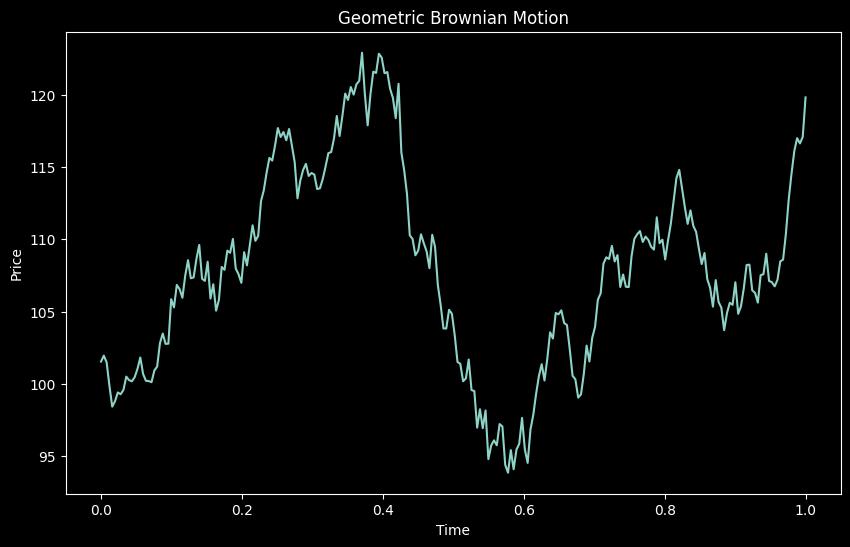

In [35]:
import numpy as np
import matplotlib.pyplot as plt

def simulate_gbm(S0, mu, sigma, T, N):
    dt = T / N
    t = np.linspace(0, T, N)
    
    W = np.cumsum(np.random.randn(N) * np.sqrt(dt))
    S = S0 * np.exp((mu - 0.5*sigma**2)*t + sigma*W)
    return t, S

S0, mu, sigma, T, N = 100, 0.05, 0.2, 1, 252
t, S = simulate_gbm(S0, mu, sigma, T, N)

plt.figure(figsize=(10,6))
plt.plot(t, S)
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Geometric Brownian Motion')
plt.show()

### Monte Carlo for European Option Pricing

In [ ]:
import numpy as np

def monte_carlo_european_call(S0, K, T, r, sigma, num_sims):
    dt = T
    U = np.random.normal(0, 1, num_sims//2)
    V = -U
    Z = np.concatenate((U, V))

    ST = S0 * np.exp((r - 0.5*sigma^2)*dt + sigma*np.sqrt(dt)*Z)
    payoff = np.maximum(ST - K, 0)
    discounted = np.exp(-r*T)*payoff
    return np.mean(discounted), np.std(discounted)/np.sqrt(num_sims)

### Value at Risk (VaR) Estimation via Monte Carlo

In [ ]:
def monte_carlo_var(initial_value, mu, sigma, T, alpha, num_sims):
    Z = np.random.normal(0, 1, num_sims)
    ST = initial_value * np.exp((mu - 0.5\sigma^2)*T + sigma*np.sqrt(T)*Z)
    losses = initial_value - ST
    var_estimate = np.percentile(losses, 100 * alpha)
    return var_estimate

### Advantages and Limitations of Monte Carlo in Finance

- **Highly flexible** for exotic instruments.  
- **Can incorporate** variance reduction, moment matching.  
- Potentially **time-consuming** for high accuracy or path-dependent derivatives.  
- **Model assumptions** (GBM, constant volatility) may deviate from reality.

---

## Conclusion

**Random number generation** (pseudo vs. quasi), **Monte Carlo fundamentals**, **variance reduction**, and **moment control** constitute a powerful toolkit for **numerical analysis** and **non-linear optimization**. Combined with knowledge of **Brownian motion** (and extensions like GBM), one can tackle **financial applications** (option pricing, VaR) and beyond. Ensuring correct **statistical moments** and employing **antithetic or quasi-random** sampling can significantly improve efficiency and realism.

---

## Consolidated Exercises

- **Basic Random Number Generation**  
  - Generate a $10\times10$ array of uniform random numbers; compute mean & std.  
  - Generate 20 random integers between 1 and 10; count frequencies.

- **Pseudo & Quasi-Random Implementation**  
  - Implement a **Linear Congruential Generator (LCG)** for 1000 samples; plot histogram.  
  - Generate & compare **Halton** vs. **Sobol** sequences in 2D.

- **Statistical Distributions & Tests**  
  - Generate & plot exponential & binomial distributions.  
  - Perform a KS test on a sample of normal random numbers.

- **Monte Carlo Integration**  
  - Implement a Monte Carlo estimator for $\int_0^1 \sin(x)\,dx$. Compare vs. standard numerical integration.  
  - Repeat with **quasi-random** sampling (Sobol/Halton). Compare convergence.

- **Brownian Motion**  
  - Simulate multiple paths of **standard Brownian motion**; check increment distribution & mean/variance.  
  - Investigate **Geometric Brownian Motion** by simulating multiple stock-price paths. Compare Euler–Maruyama vs. exponential discretization.  
  - Explore the **Reflection Principle** numerically.

- **Variance Reduction: Antithetic Variables**  
  - Implement a Monte Carlo estimator for $\mathbb{E}[X]$, $X\sim \mathcal{N}(0,1)$ using antithetic pairs. Compare variance vs. independent sampling.  
  - Modify $\pi$-estimation code to see how quickly it converges with vs. without antithetic.

- **Moment Control**  
  - Generate normal samples with a specific mean & variance; verify the match.  
  - Attempt to adjust skewness & kurtosis for a sample; discuss limitations.  
  - Integrate moment-controlled samples into a basic Monte Carlo simulation and observe differences.

- **Stochastic Modeling in Finance**  
  - Compare a simple **Black–Scholes** formula for a European call vs. a Monte Carlo estimate.  
  - Investigate how changing **volatility** $(\sigma)$ affects the price under Black–Scholes vs. Monte Carlo.  
  - Use the **monte_carlo_var** function to estimate 99% VaR and interpret the result.